# Introduction

GANs were introduced by Goodfellow et al. in [this](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) famous paper. The idea, in a nutshell, is to make two networks - the generator network and the discriminator network compete with other in a minimax game. The generator tries to fool the discriminator creating more and more realistic images, and the discriminator tries not to be fooled by the generator.

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adagrad, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

In [0]:
# Suppresses trainable weights related warnings
def _check_trainable_weights_consistency(self):
    return
tf.keras.Model._check_trainable_weights_consistency = _check_trainable_weights_consistency

# Helper Functions
Let's write a helper function to plot images in a grid. 

In [0]:
def plot_grid(images, rows, cols, figsize=(10, 10)):
    sample_ids = np.random.randint(0, images.shape[0], size=rows*cols)
    sample = images[sample_ids]
    f, ax_arr = plt.subplots(rows, cols, figsize=figsize)
    plt.set_cmap(plt.cm.Greys_r)
    index = 0
    for i in range(rows):
        for j in range(cols):
            ax_arr[i, j].imshow(sample[index])
            ax_arr[i, j].axis('off')
            index +=1
    plt.show()
    plt.close()

# Load the MNIST training dataset
We convert the images from `[0, 255]` to `[-1, 1]` as our generator network has a Tanh output activation layer (as you will see later) and Tanh has a range of `[-1, 1]`. We also display 36 images from the dataset at random.

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_train = 2 * (x_train - 0.5)
print('Max value:', x_train.max())
print('Min value:', x_train.min())
print('Loaded dataset tensor size:', x_train.shape)
dataSize = x_train.shape[0]
dimSize = x_train.shape[1] * x_train.shape[2]

11493376/11490434 [==============================] - 0s 0us/step
Max value: 1.0
Min value: -1.0
Loaded dataset tensor size: (60000, 28, 28)


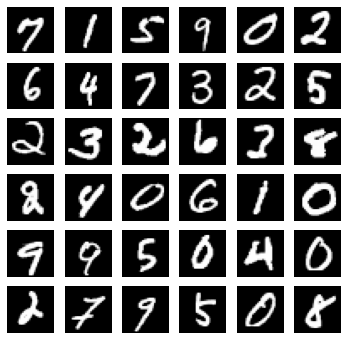

In [0]:
plot_grid(x_train, 6, 6, figsize=(6, 6))

# Define Generator Network
The Generator Network takes in a random vector of size `100` and outputs `28x28` numbers which are reshaped to produce the image. We use `LeakyReLU` as the activation function which are the way to go for GANs as they facilitate better gradient flow by avoiding sparse gradients, however, you can experiment with regular `ReLU` and see if it matters for our case.

We use He Uniform initialization as it worked better, feel free to experiment with other initialization schemes to see what you get.

In [0]:
n_hidden = 128
z_dim = 100

# Generator
model_g = Sequential()
model_g.add(Dense(n_hidden, input_shape=(z_dim,), kernel_initializer='he_uniform'))
model_g.add(LeakyReLU(0.01))
model_g.add(Dense(dimSize, kernel_initializer='he_uniform'))
model_g.add(Activation('tanh'))

In [0]:
model_g.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               101136    
_________________________________________________________________
activation (Activation)      (None, 784)               0         
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________


# Define Discriminator Network
The Discriminator Network is a binary classifier. It takes in an image of size `28x28` and has two output neurons corresponding to the two classes: **Real** and **Fake**. We use `LeakyReLU` for the same reason as before. 

Applying a `Softmax` at the end led to mode collapse, so we use the logits directly and will use `SparseCategoricalCrossentropy` with `logits` arugment set to `True` later as the loss function. Feel free to experiment with `Softmax` and `SparseCategoricalCrossentropy` set to `False`.

In [0]:
model_d = Sequential()
model_d.add(Dense(n_hidden, input_shape=(dimSize,), kernel_initializer='he_uniform'))
model_d.add(LeakyReLU(0.01))
model_d.add(Dense(2, kernel_initializer='he_uniform'))

In [0]:
model_d.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 100,738
Trainable params: 100,738
Non-trainable params: 0
_________________________________________________________________


# Training
Let's define some hyperparameters and helper functions to fetch real and fake batches for training the GAN.

In [0]:
# Hyperparameters
batchSize = 32
batchSizeHalf = batchSize / 2

# Total batches that can be created from the training set
nBatches = math.floor(dataSize / batchSizeHalf)

In [0]:
def get_real_batch(batchData, batchId, shuffle, batchSize):
    start_idx = int(batchId * batchSize)
    end_idx = int((batchId + 1) * batchSize)
    indices = shuffle[start_idx:end_idx]
    num_samples = indices.shape[0]
    return batchData[indices].reshape(num_samples, dimSize)

In [0]:
def get_fake_batch(generator, latent_dim, batchSize):
    z = np.random.rand(batchSize, latent_dim) - 0.5
    fakes = generator.predict(z)
    return fakes

# Cost Function and Optimizers
We will use the cross entropy function `SparseCategoricalCrossentropy` to train both the Discriminator and the Generator networks. As we didn't apply a `Softmax` on the discriminator's output, we will set `logits` argument to `True`.

We use `Adagrad` with a learning rate of `0.1`. Feel free to experiment with different optimizers and learning rates.

In [0]:
optim_d = Adagrad(0.1)
optim_g = Adagrad(0.1)
criterion = SparseCategoricalCrossentropy(from_logits=True)
maxEpoch = 20

# Main Training Loop

We run the training loop from `1` to a desired number of epochs `maxEpoch` where we train both our networks in an alternate fashion. 

## Discriminator
The input to the Discriminator is `X`, which contains `batchSize` images. The first half are real images randomly drawn from the training set and the latter half are generated images. Similarly, the first half of labels `Y` is `1` corresponding to Real labels and the latter half is `0` (Fake labels). Now that we have the input and the corresponding outputs, we train the discriminator like we would train any other classifier. Compute the loss using the criterion, backward through the model to calculate the gradients and let the optimizer use the gradients computed in the backward pass to update the weights of the discriminator.

# Generator
The input to the Generator is a noise vector `z`, which contains `batchSize` random vectors of size `z_dim` sampled from a uniform distribution, shifted to the range `[-0.5, 0.5]`. The Generator produces `predictions`, which are `batchSize` `28x28` fake images. We pass these through the discriminator network and then compute the loss with the lables flipped (since we now want the discriminator to output the label Real for these images). We compute the gradients for this loss and backpropagage through the discriminator Network. Once we reach the input layer of the Discriminator, we then pass the gradients of the loss with respect to the input of the discriminator network to the output layer of the generator network and continue to backpropagate through the generator network. Finally, having obtained the gradients for the generator weights, we update the weights of the generator.

100%|██████████| 3750/3750 [02:59<00:00, 20.92it/s]


Epoch 1  out of 20  done !!!


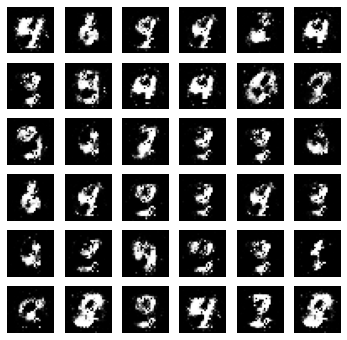

100%|██████████| 3750/3750 [02:57<00:00, 21.14it/s]


Epoch 2  out of 20  done !!!


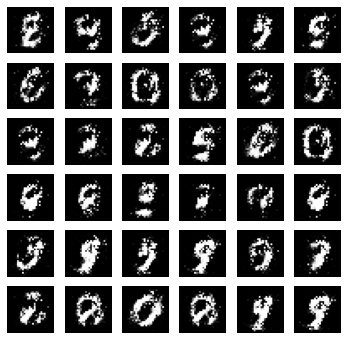

100%|██████████| 3750/3750 [02:56<00:00, 21.21it/s]


Epoch 3  out of 20  done !!!


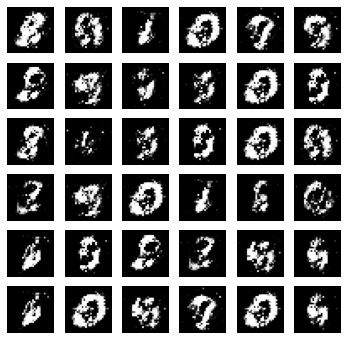

100%|██████████| 3750/3750 [02:57<00:00, 21.16it/s]


Epoch 4  out of 20  done !!!


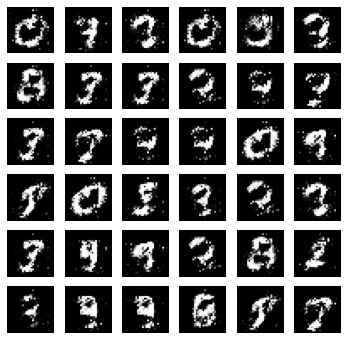

100%|██████████| 3750/3750 [02:56<00:00, 21.27it/s]


Epoch 5  out of 20  done !!!


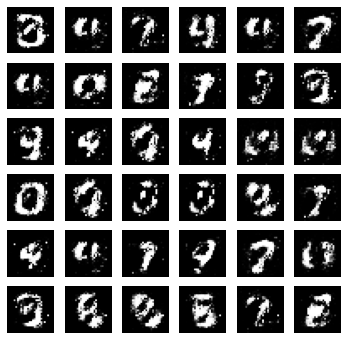

100%|██████████| 3750/3750 [02:56<00:00, 21.20it/s]


Epoch 6  out of 20  done !!!


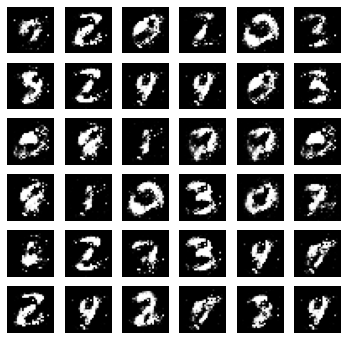

100%|██████████| 3750/3750 [02:56<00:00, 21.24it/s]


Epoch 7  out of 20  done !!!


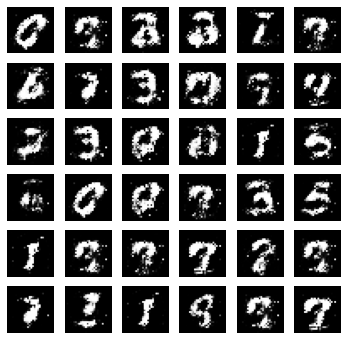

100%|██████████| 3750/3750 [03:01<00:00, 20.68it/s]


Epoch 8  out of 20  done !!!


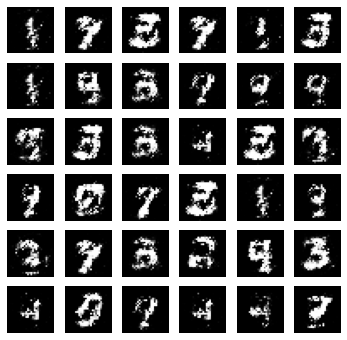

100%|██████████| 3750/3750 [03:03<00:00, 20.40it/s]


Epoch 9  out of 20  done !!!


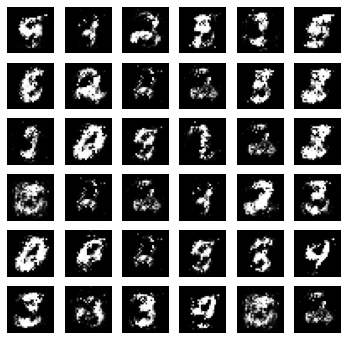

100%|██████████| 3750/3750 [03:02<00:00, 20.55it/s]


Epoch 10  out of 20  done !!!


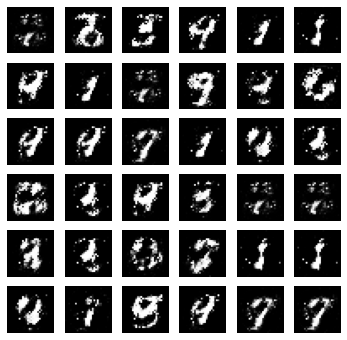

100%|██████████| 3750/3750 [03:03<00:00, 20.46it/s]


Epoch 11  out of 20  done !!!


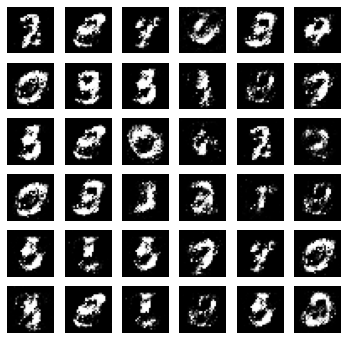

100%|██████████| 3750/3750 [03:01<00:00, 20.70it/s]


Epoch 12  out of 20  done !!!


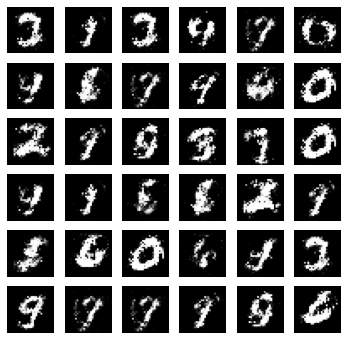

100%|██████████| 3750/3750 [02:55<00:00, 21.35it/s]


Epoch 13  out of 20  done !!!


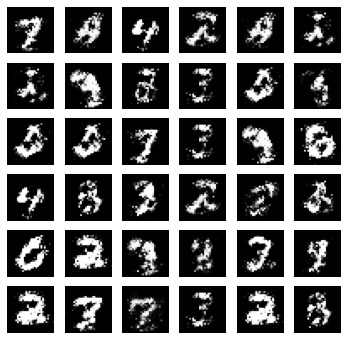

100%|██████████| 3750/3750 [02:58<00:00, 21.03it/s]


Epoch 14  out of 20  done !!!


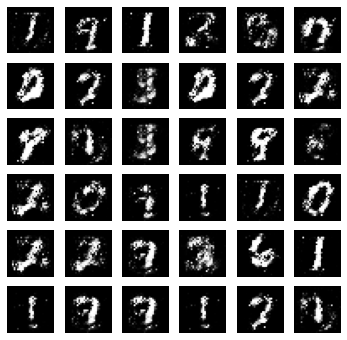

100%|██████████| 3750/3750 [02:59<00:00, 20.88it/s]


Epoch 15  out of 20  done !!!


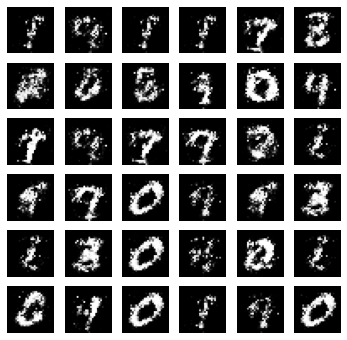

100%|██████████| 3750/3750 [03:01<00:00, 20.72it/s]


Epoch 16  out of 20  done !!!


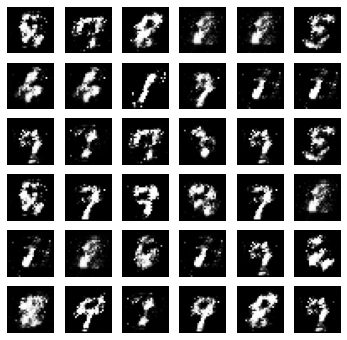

100%|██████████| 3750/3750 [02:59<00:00, 20.87it/s]


Epoch 17  out of 20  done !!!


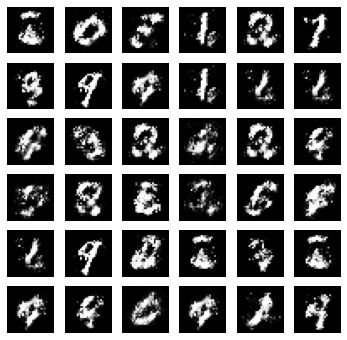

100%|██████████| 3750/3750 [02:56<00:00, 21.19it/s]


Epoch 18  out of 20  done !!!


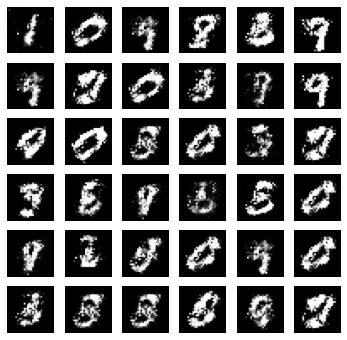

100%|██████████| 3750/3750 [02:56<00:00, 21.24it/s]


Epoch 19  out of 20  done !!!


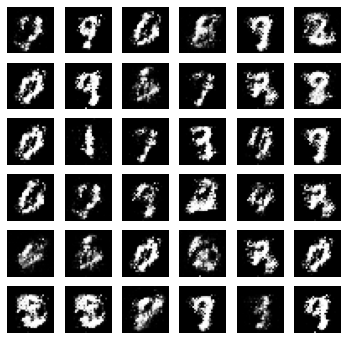

100%|██████████| 3750/3750 [02:56<00:00, 21.22it/s]


Epoch 20  out of 20  done !!!


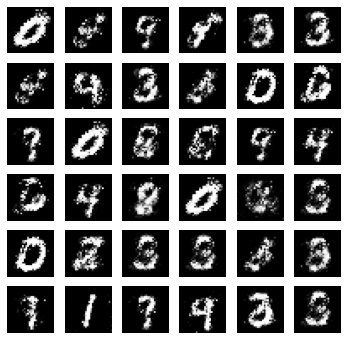

In [0]:
shuffle = np.arange(dataSize)

for epochId in range(maxEpoch):
    np.random.shuffle(shuffle)
    
    for batch_id in tqdm(range(nBatches)):
        # Train the discriminator
        x_real = get_real_batch(x_train, batch_id, shuffle, batchSizeHalf)
        y_real = np.ones((x_real.shape[0], 1))
        
        x_fake = get_fake_batch(model_g, z_dim, x_real.shape[0])
        y_fake = np.zeros((x_real.shape[0], 1))
        
        X, Y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
        with tf.GradientTape() as tape:
            predictions = model_d(X)
            d_loss = criterion(Y, predictions)
        grads = tape.gradient(d_loss, model_d.trainable_weights)
        optim_d.apply_gradients(zip(grads, model_d.trainable_weights))
        
        # Train the generator 
        z = np.random.rand(batchSize, z_dim) - 0.5
        labels = np.ones((batchSize, 1))
        
        with tf.GradientTape() as tape:
            predictions = model_d(model_g(z))
            g_loss = criterion(labels, predictions)
        grads = tape.gradient(g_loss, model_g.trainable_weights)
        optim_g.apply_gradients(zip(grads, model_g.trainable_weights))
    
    print('Epoch', epochId + 1, ' out of', maxEpoch, ' done !!!')
    noise = np.random.rand(36, z_dim) - 0.5
    randImgs = model_g.predict(noise)
    randImgs = randImgs.reshape(36, 28, 28)
    plot_grid(randImgs, 6, 6, figsize=(6, 6))